# Dog Breed Classifier App
## This notebook is about building dog breed classifier, and to add some fun to it, it will display the most resembling dog breed if a human image is passed to it
### Steps:
* We need to build dog detector, and human face detector.
* Next we will build a CNN from scratch to classify the dog breeds.
* Then we will build a CNN using transfer learnig and compare results to choose the best one 

In [1]:
import numpy as np
from glob import glob

# Load file named for human and dog images
human_files = np.array(glob('/kaggle/input/human-dataset/lfw/*/*'))
dog_files = np.array(glob("/kaggle/input/dog-breeds-images/dogImages/*/*/*"))

# Data sets lengths
print("Human dataset containes {} images".format(len(human_files)))
print("Dog dataset containes {} images".format(len(dog_files)))

Human dataset containes 13233 images
Dog dataset containes 8351 images


# Extract an OpenCv face detector and test it

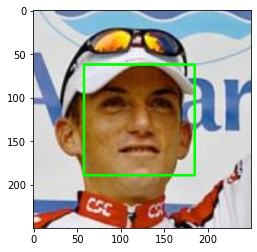

In [2]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# extract pre-trained "haarcascade_frontalface" detector
face_cascade_detector = cv2.CascadeClassifier('../input/face-detector-alt2/haarcascade_frontalface_alt2.xml')

# Load (BGR) image
img = cv2.imread(human_files[0])

# convert img to gray scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# find faces in the image
faces = face_cascade_detector.detectMultiScale(gray)

# add bounding box for each face
for x, y, w, h in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
# convert BGR img to RGB
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the RGB img
plt.imshow(cv_rgb)
plt.show()

# Human face detector Function

In [3]:
def face_detector(img_path):
    '''
    Function To detect human faces in certian image
    params:
        img_path (string) : The path to the image
    Reterns:
        (bool): True if there is any detected human face in the image, else returns False
    '''
    
    # loading BGR image
    img = cv2.imread(img_path)
    # Convert to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # detect faces in the image
    faces = face_cascade_detector.detectMultiScale(gray)
    
    return len(faces) > 0  

# Test our human face dector

In [4]:
from tqdm import tqdm


# extract 100 images form human and dogs images
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

detected_faces_human = 0
detected_faces_dog = 0

# How many detected faces in human_files_short
for img_path in tqdm(human_files_short):
    if face_detector(img_path):
        detected_faces_human += 1

# How many detected faces in dog_files_short
for img_path in tqdm(dog_files_short):
    if face_detector(img_path):
        detected_faces_dog += 1

# Printing results
print("Detects {} faces in human images.\tPercentage {}.".format(detected_faces_human, detected_faces_human/len(human_files_short)))
print("Detects {} faces in dog images. \tPercentage {}.".format(detected_faces_dog, detected_faces_dog/len(dog_files_short)))   

100%|██████████| 100/100 [00:32<00:00,  3.10it/s]

Detects 100 faces in human images.	Percentage 1.0.
Detects 15 faces in dog images. 	Percentage 0.15.


# Use pretrained model (VGG16) to detect dog images

In [5]:
import torch
import torchvision.models as models

# Obtain VGG-16 model
vgg = models.vgg16(pretrained=True)

use_cuda = torch.cuda.is_available()

if use_cuda:
    print("GPU is available")
    vgg = vgg.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



GPU is available


In [6]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Dog detector function using VGG-16

In [7]:
from PIL import Image
import torchvision.transforms as transforms

def vgg_predict(img_path):

    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    # Load the image
    img = Image.open(img_path)
    
    # Some proprocessing to our image
    img_transforms = transforms.Compose([transforms.Resize(224),
                                        transforms.ToTensor(),
                                        transforms.transforms.Normalize([0.485, 0.456, 0.406],
                                                                        [0.229, 0.224, 0.225])])
    # Apply transformations to the iamge
    img = img_transforms(img)
    img = img.view(1, *img.shape)
    img.requires_grad = False
    
    # Move image to cuda if available
    if use_cuda:
        img = img.cuda()

    with torch.no_grad():
        output = vgg(img)
        
    # get the top predicted index    
    _, top_class = output.topk(1, dim=1)
    
    return top_class.item()

# Dogs appear in ImageNet categories between 151-268 inclusive

In [8]:
def dog_detector_vgg(img_path):
    output = vgg_predict(img_path)
    # check if the output is in dogs idecies range
    result = output >= 151 and output <= 268
    
    return result    

# Test our function

In [9]:
# Initialize the number of detected dogs in human files and dog files to 0
detected_dogs_human = 0
detected_dogs_dogs = 0

print("Scanning Human Files....")
for img in tqdm(human_files_short):
    if dog_detector_vgg(img):
        detected_dogs_human += 1

print("Scanning Dog Files....")
for img in tqdm(dog_files_short):
    if dog_detector_vgg(img):
        detected_dogs_dogs += 1

print("======================= Number Of Detected Dogs =======================")
print("Human Images: {}\tPercentage: {}%.".format(detected_dogs_human,
                                                 detected_dogs_human/len(human_files_short) * 100))
print("Dogs Images: {}\tPercentage: {}%.".format(detected_dogs_dogs,
                                                 detected_dogs_dogs/len(dog_files_short) * 100))

  0%|          | 0/100 [00:00<?, ?it/s]

Scanning Human Files....


  8%|▊         | 8/100 [00:00<00:01, 71.69it/s]

Scanning Dog Files....


100%|██████████| 100/100 [00:01<00:00, 53.01it/s]

======================= Number Of Detected Dogs =======================
Human Images: 0	Percentage: 0.0%.
Dogs Images: 99	Percentage: 99.0%.


# Building dog breed calssifier from scratch using CNN

### Compute mean and std

In [10]:
import os
from torchvision import datasets

transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])

data_dir = "../input/dog-breeds-images/dogImages"
data = datasets.ImageFolder(data_dir, transform=transform)

In [11]:
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

mean = [] # list to append all images(3 channels) means one by one
std = [] # list to append all images(3 channels) stds one by one

# Calculating mean and std for each image
for img, _ in data:
    mean.append([torch.mean(ch) for ch in img])
    std.append([torch.std(ch) for ch in img])
    
# Calculating mean and std for all images   
mean = torch.mean(torch.Tensor(mean), axis=0) # one mean for all images(3 channels)
std = torch.mean(torch.Tensor(std), axis=0) # one std for all images(3 channels)

In [12]:
print(mean)
print(std)

tensor([0.4862, 0.4557, 0.3915])
tensor([0.2304, 0.2256, 0.2233])


### Writing Data loaders for Dog dataset

In [13]:
train_dir = os.path.join(data_dir, "train/")
valid_dir = os.path.join(data_dir, "valid/")
test_dir = os.path.join(data_dir, "test/")

normalize = transforms.Normalize(mean, std)
train_transforms = transforms.Compose([transforms.RandomRotation(10),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       normalize])

test_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                      normalize])

train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

# batch size
batch_size = 32
# Data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

loaders = {"train": train_loader, "valid": valid_loader, "test": test_loader}

### Creating CNN model to calssify dog breeds

In [14]:
# helper function to create Conv layer with batch noramlization
def conv(in_channels, out_channels, kernel_size, stride=1, padding=1, batch_norm=True):
    layers = []
    layers.append(nn.Conv2d(in_channels, out_channels, kernel_size,
                            stride=stride, padding=padding, bias=False))
    
    # append batch normalization layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [15]:
# helper function to create Linear layer with batch noramlization
def linear(in_features, out_features, batch_norm=True):
    layers = []
    layers.append(nn.Linear(in_features, out_features, bias=False))
    
    if batch_norm:
        layers.append(nn.BatchNorm1d(out_features))
    
    return nn.Sequential(*layers)

In [16]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Layers for CNN (feature extractor)
        self.conv1 = nn.Conv2d(3, 32, 1, padding=1)
        self.conv2 = conv(32, 32, 3)
        self.conv3 = conv(32, 64, 3)
        
        self.conv4 = conv(64, 128, 3)
        self.conv5 = conv(128, 128, 3)
        
        self.conv6 = conv(128, 256, 3)
        self.conv7 = conv(256, 512, 3)
        self.conv8 = conv(512, 512, 3)
        
        self.conv9 = conv(512, 1024, 3)
        
        self.conv10 = conv(1024, 1024, 3)
               
        # Max pool
        self.pool = nn.MaxPool2d(2, 2)

        # Classifier
        self.fc1 = linear(1024*7*7, 512)
        self.fc2 = nn.Linear(512, 133)

        self.drop = nn.Dropout(0.5)
    
    def forward(self, x):
        # Each image in the batch has shape of (3, 224, 224)
        x = F.relu(self.conv1(x)) # output -> (32, 224, 224)
        x = F.relu(self.conv2(x)) # output -> (32, 224, 224)
        x = F.relu(self.conv3(x)) # output -> (64, 224, 224)
        x = self.pool(x) # output -> (64, 112, 112)
        
        x = F.relu(self.conv4(x)) # output -> (128, 112, 112)
        x = F.relu(self.conv5(x)) # output -> (128, 112, 112)
        x = self.pool(x) # output -> (128, 56, 56)
        
        x = F.relu(self.conv6(x)) # output -> (256, 56, 56)
        x = F.relu(self.conv7(x)) # output -> (256, 56, 56)
        x = F.relu(self.conv8(x)) # output -> (512, 56, 56)
        x = self.pool(x) # output -> (512, 28, 28)
        
        x = F.relu(self.conv9(x)) # output -> (1024, 28, 28)
        x = self.pool(x) # output -> (1024, 14, 14)
        
        x = F.relu(self.conv10(x)) # output -> (1024, 14, 14)
        x = self.pool(x) # output -> (1024, 7, 7)
        
        # flatten x to feed it to the classifier
        x = x.view(-1, 1024*7*7)
        
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        
        return x


# Weight Initialization
### Weight Initialization helps the model converge faster

In [17]:
from torch.nn import init

# helper function to initialize weights using normal distrobution
def init_weights(m):
    
    class_name = m.__class__.__name__
    
    if hasattr(m, "weight") and (class_name.find("Conv") != -1 or class_name.find("Linear") != -1):
        init.normal_(m.weight.data,0 , 0.02)
    
    if hasattr(m, "bias") and m.bias is not None:
        init.constant_(m.bias.data, 0.0)
    

In [18]:
# model creation
def create_model():
    model = Net()
    model.apply(init_weights)
    print(model)
    return model

In [19]:
model_scratch = create_model()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv5): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv6): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bi

In [20]:
def train(n_epochs, model, loaders, optimizer, criterion, scheduler, use_cuda, save_path):
    ''' This function takes untrained model and returns it trained.
    params:
        n_epochs: number of epochs for training the whole dataset
        model : the model we want to train
        loaders: dictionary containes data loaders for (training, validation, test) sets
        optimzer: the optimizer you want to use with this model
        criterion: loss function
        use_cuda: boolean value represents the state of GPU (available or not available)
        save_path: the path where the best model during training will be saved
    
    returns: 
        model: the trained model
    '''
    
    # move the model to the gpu if available
    if use_cuda:
        print("GPU is avilable.....")
        model = model.cuda()
    # Initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
        # print current epoch nymber and current learning rate
        print("\n[Epoch]: {}\t [lr]: {}.....".format(epoch, scheduler.get_last_lr()))
        
        # Initialize variables to monitor train_loss and valid_loss
        train_loss = 0
        valid_loss = 0
        
        ###########################
        ######### Training ########
        ###########################
        
        # train mode
        model.train()
        # track the total number of images to calculate the average loss
        total_images = 0
        
        for inputs, target in loaders["train"]:
            # move to gpu if available
            if use_cuda:
                inputs, target = inputs.cuda(), target.cuda()
            
            optimizer.zero_grad()
            
            out = model(inputs)
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()
            
            # updating the training loss value
            train_loss += loss.item() * inputs.size(0)
            # updating the number of the images
            total_images += len(target)
        
        # calculating the average loss of the whole data set
        train_loss = train_loss / total_images
        
        ###########################
        ######## Validation #######
        ###########################
        
        # evaluation mode 
        model.eval()
        # reset the number of images
        total_images =0

        for inputs, target in loaders["valid"]:
            # move to gpu if avilable
            if use_cuda:
                inputs, target = inputs.cuda(), target.cuda()
            
            out = model(inputs)
            loss = criterion(out, target)
            
            valid_loss += loss.item() * inputs.size(0)
            total_images += len(target)
        
        # calculate the average validation loss for the whole data set
        valid_loss = valid_loss / total_images
        # print the epoch stats
        print("Training Loss: {:.5f}, Validation Loss: {:.5f}".format(train_loss, valid_loss))
        
        if valid_loss < valid_loss_min:
            print("Saving the new model.....")
            # Save the new better model
            torch.save(model.state_dict(), save_path)
            # updating valid_loss_min
            valid_loss_min = valid_loss
        
        # change lr for next epoch
        scheduler.step()
        
    return model
            

In [21]:
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [22]:
import torch.optim as optim
# loss function and the optimizer
criterion_scratch = nn.CrossEntropyLoss()
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.001)
# learning rate scheduler to decay it along epochs
scheduler = optim.lr_scheduler.MultiStepLR(optimizer_scratch, milestones=[35, 80], gamma=0.5)

In [23]:
# model_scratch.load_state_dict(torch.load('./model_scratch.pt'))
save_path = "model_scratch.pt"
model_scratch = train(50, model_scratch, loaders, 
                      optimizer_scratch, criterion_scratch, scheduler, use_cuda, save_path)

GPU is avilable.....

[Epoch]: 1	 [lr]: [0.001].....
Training Loss: 4.92011, Validation Loss: 4.66241
Saving the new model.....

[Epoch]: 2	 [lr]: [0.001].....
Training Loss: 4.66458, Validation Loss: 4.50595
Saving the new model.....

[Epoch]: 3	 [lr]: [0.001].....
Training Loss: 4.53589, Validation Loss: 4.49936
Saving the new model.....

[Epoch]: 4	 [lr]: [0.001].....
Training Loss: 4.42087, Validation Loss: 4.33066
Saving the new model.....

[Epoch]: 5	 [lr]: [0.001].....
Training Loss: 4.33701, Validation Loss: 4.34557

[Epoch]: 6	 [lr]: [0.001].....
Training Loss: 4.28789, Validation Loss: 4.29520
Saving the new model.....

[Epoch]: 7	 [lr]: [0.001].....
Training Loss: 4.21871, Validation Loss: 4.21064
Saving the new model.....

[Epoch]: 8	 [lr]: [0.001].....
Training Loss: 4.12271, Validation Loss: 4.40968

[Epoch]: 9	 [lr]: [0.001].....
Training Loss: 4.09137, Validation Loss: 4.31441

[Epoch]: 10	 [lr]: [0.001].....
Training Loss: 4.02181, Validation Loss: 4.14594
Saving the n

In [24]:
# load the best model according to validation loss
model_scratch.load_state_dict(torch.load('./model_scratch.pt'))

<All keys matched successfully>

# Test function

In [25]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))

In [26]:
test(loaders, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.289941


Test Accuracy: 39% (330/836)


# Using Transfer learning

In [28]:
import torchvision.models as models

# Instantiate resnet model from pretrained resnet50 model
resnet_model = models.resnet50(pretrained=True)

# Get the number of input features for the model classifier
n_inputs = resnet_model.fc.in_features

# Define a new classifier for our resnet_model
# resnet_model.fc = nn.Linear(n_inputs, 133)
resnet_model.fc = nn.Sequential(linear(n_inputs, 512),
                                nn.ReLU(),
                                nn.Dropout(0.5),
                                linear(512, 133),
                                nn.ReLU(),
                                nn.Dropout(0.5),
                                nn.Linear(133, 133))

# freeze parameters in resnet_model feature extractor
for param in resnet_model.parameters():
    param.requires_grad = False

for param in resnet_model.fc.parameters():
    param.requires_grad = True
# move the model to gpu if available
if use_cuda:
    resnet_model = resnet_model.cuda()
    print("GPU is working, moving the model......")
    
print(resnet_model)

GPU is working, moving the model......
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(6

In [60]:
# loss function and the optimizer
criterion_resnet = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(resnet_model.fc.parameters(), lr=0.001)
# learning rate scheduler to decay it along epochs
scheduler_resnet = optim.lr_scheduler.MultiStepLR(optimizer_resnet, milestones=[30], gamma=0.5)

In [61]:
save_path = "resnet_model.pt"
model_scratch = train(30, resnet_model, loaders, 
                      optimizer_resnet, criterion_resnet, scheduler_resnet, use_cuda, save_path)

GPU is avilable.....

[Epoch]: 1	 [lr]: [0.001].....
Training Loss: 1.14524, Validation Loss: 0.91415
Saving the new model.....

[Epoch]: 2	 [lr]: [0.001].....
Training Loss: 1.17970, Validation Loss: 0.87988
Saving the new model.....

[Epoch]: 3	 [lr]: [0.001].....
Training Loss: 1.18059, Validation Loss: 0.85076
Saving the new model.....

[Epoch]: 4	 [lr]: [0.001].....
Training Loss: 1.20637, Validation Loss: 0.91232

[Epoch]: 5	 [lr]: [0.001].....
Training Loss: 1.16184, Validation Loss: 0.87984

[Epoch]: 6	 [lr]: [0.001].....
Training Loss: 1.15864, Validation Loss: 0.80625
Saving the new model.....

[Epoch]: 7	 [lr]: [0.001].....
Training Loss: 1.14710, Validation Loss: 0.82283

[Epoch]: 8	 [lr]: [0.001].....
Training Loss: 1.14873, Validation Loss: 0.88961

[Epoch]: 9	 [lr]: [0.001].....
Training Loss: 1.10720, Validation Loss: 0.85161

[Epoch]: 10	 [lr]: [0.001].....
Training Loss: 1.13534, Validation Loss: 0.91086

[Epoch]: 11	 [lr]: [0.001].....
Training Loss: 1.12674, Validat

In [62]:
resnet_model.load_state_dict(torch.load('./resnet_model.pt'))

<All keys matched successfully>

In [63]:
test(loaders, resnet_model, criterion_resnet, use_cuda)

Test Loss: 0.482878


Test Accuracy: 86% (719/836)


# It is clear that the results from the resnet_model is much better, so we are going to use it in our algorithm

### Function to predict the breed of the image

In [64]:
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in train_data.classes]

def predict_breed_resnet(img_path):
    """
    Use resnet_model to obtain the breed 
    for the image at specified path.
    
    Args:
        img_path: path to an image
        
    Returns:
        Class name corresponding to the breed of this image
        Index corresponding to this class name
    """
    
    # load the image and return the predicted breed
    img_transform = transforms.Compose([transforms.Resize((224, 224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
    
    img = Image.open(img_path)
    img = img_transform(img)
    img = img.view(1, *img.shape)
    
    if use_cuda:
        img = img.cuda()
    
    img.requires_grad = False
    
    with torch.no_grad():
        output = resnet_model(img)
        
    _, top_class = output.topk(1, dim=1)
    breed_idx = top_class.item()
    
    return class_names[breed_idx], breed_idx

### Function to predict the breed of the image if it is a dog

In [65]:
def predict_breed_dog(img_path):
    
    """
    Use resnet_model to obtain the breed 
    for the dog image at specified path, then display the image with 
    it's breed name.
    
    Args:
        img_path: path to a dog image
        
    Returns:
        None
    """
    
    breed, breed_idx = predict_breed_resnet(img_path)
    print("Hi ( {} ) dog!".format(breed))
    
    dog_img = cv2.imread(img_path)
    dog_img = cv2.cvtColor(dog_img, cv2.COLOR_BGR2RGB)
    
    plt.imshow(dog_img)
    plt.show()

### Function to predict the resembling dog breed if the provided image is a human image

In [66]:
def predict_breed_human(img_path):
    """
    Use resnet_model to obtain the resembling dog breed 
    for the human image at specified path, 
    then display the human image with it's resembling dog breed name
    alongside a dog image example from this breed.
    
    Args:
        img_path: path to a human image 
        
    Returns:
        None
    """
    
    # retrieve data about image  (breed, breed index)
    breed, breed_idx = predict_breed_resnet(img_path)
    # print the most resembling dog breed
    print("You look like: {}!  check it yourself".format(breed))
    
    # get all images paths for this breed in test images to display one of them
    breed_dir = test_data.classes[breed_idx]
    breed_dir = "../input/dog-breeds-images/dogImages/test/" + breed_dir + "/*"
    dog_files = np.array(glob(breed_dir))
    
    # select random image to be shown to the user next to his image
    dog_img_path = np.random.choice(dog_files, 1).item()
    dog_img = cv2.imread(dog_img_path)
    
    # read human image
    human_img = cv2.imread(img_path)
    
    # convert images to RGB display them
    dog_img = cv2.cvtColor(dog_img, cv2.COLOR_BGR2RGB)
    human_img = cv2.cvtColor(human_img, cv2.COLOR_BGR2RGB)
    
    # display the images
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.imshow(human_img)
    ax2.imshow(dog_img)
    plt.show()

### Now it is the time to test our app

In [67]:
def run_app(img_path):
    
    # handle cases for a human face, dog, and neither
    if dog_detector_vgg(img_path):
        predict_breed_dog(img_path)
        
    elif face_detector(img_path):
        predict_breed_human(img_path)
        
    else:
        # customize the font
        FAIL = '\033[91m'
        BOLD = '\033[1m'
        
        # print error message
        print (FAIL + BOLD + "Error, please provide valid photo: (Human face or Dog)!")
    
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.show()

Hi ( Lakeland terrier ) dog!


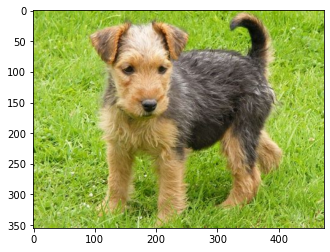

Hi ( English setter ) dog!


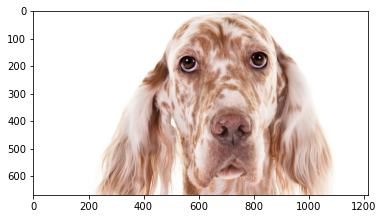

Error, please provide valid photo: (Human face or Dog)!


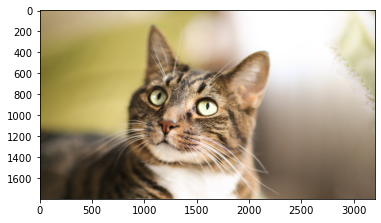

You look like: American staffordshire terrier!  check it yourself


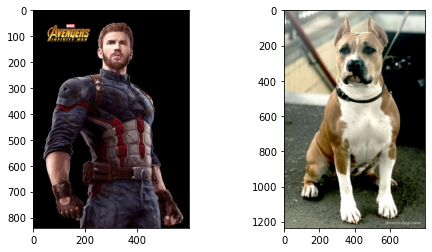

Error, please provide valid photo: (Human face or Dog)!


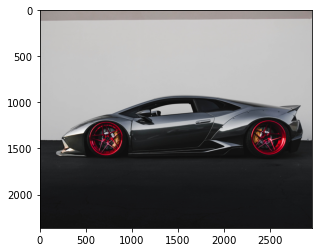

You look like: Dalmatian!  check it yourself


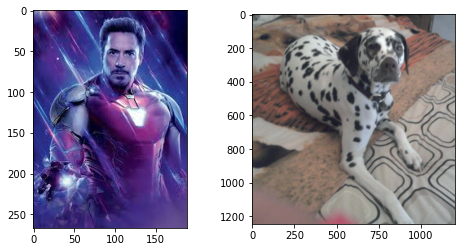

You look like: Dogue de bordeaux!  check it yourself


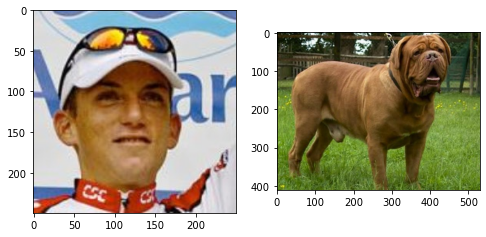

You look like: Pharaoh hound!  check it yourself


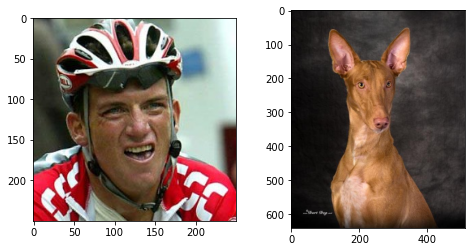

You look like: Cairn terrier!  check it yourself


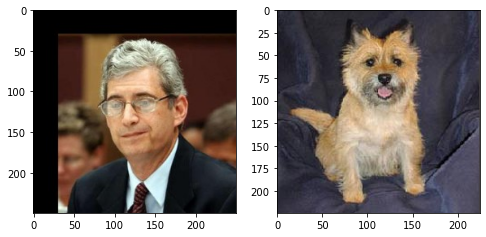

Hi ( Lowchen ) dog!


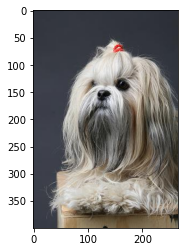

Hi ( Lhasa apso ) dog!


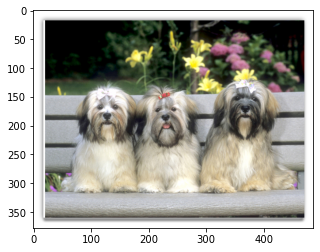

Hi ( Lhasa apso ) dog!


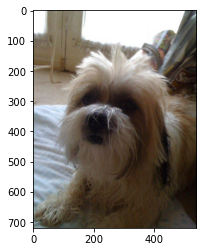

In [68]:
images_list = ["Lakeland terrier.jpg", "English setter.jpg", "cat.jpg", "captain.jpg", "car.jpg", "iron man.jpg"]

for img in images_list:
    run_app("../input/sample/" + img)
    
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)